In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

from time import time

from functools import partial


import sys
sys.path.append('../../')

from Environment import SpringMass
from Subroutines import ModelEstV4,ApproxDAP,max_norm,find_stable_radius,SafeTransit
from time import time
from Controllers import SafeDAP
from scipy.linalg import sqrtm
import pickle as pkl
%load_ext autoreload
%autoreload 2

In [2]:
class TimeStepsReached(Exception):
    pass
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

# Set up the system

## Find a highly stable spring-mass system

In [3]:
H_benchmark = 20
eps = 0.1
rho_target = eps**(1/H_benchmark)

In [4]:
rho_target

0.8912509381337456

Spectral radius of A: 0.985302581816169 0.05243679563758973 0.29703190222767073
Step 0
Step 100


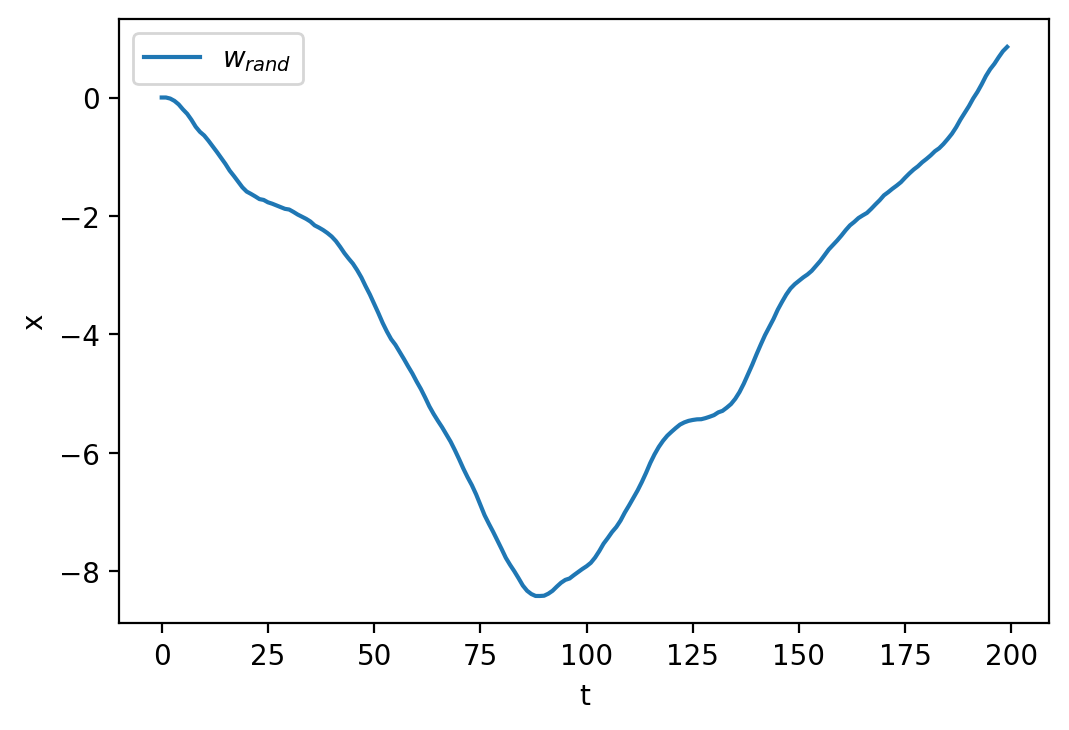

In [5]:
w_max = 0.3


dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.03
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0,w_max=w_max)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

In [6]:

A = env.A
B = env.B


# Experiments

## Experiment parameters

In [7]:
# Constants
x_dim = A.shape[-1]
u_dim = B.shape[-1]

I_x = np.eye(x_dim)  
I_u = np.eye(u_dim)  

w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.

# Optimaization Problem Parameters

Q = np.array([[1,0],
                [0,1]])*1
R = np.eye(u_dim)*1

D_x = np.vstack([I_x,-I_x]) # Constraints
# d_x = np.array([0.5,0.5,0.5,0.5])
d_x = np.array([4.0,4.0,4.0,4.0])

D_u = np.vstack([I_u,-I_u])
d_u = np.array([10.0,10.0])

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0

refit_per_step = 50
pre_run_steps = 20
TD_steps  = 30 # The least number of steps taken in Phase 1.


def PlainSim(timesteps,n_trials):
    
    def main_loop():
        env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0,w_max = w_max)

        x_no_control_hist = []
        # main loop
        for _ in range(timesteps):
            x = env.state()
            u = 0 
            env.step(u)

            x_no_control_hist.append(x)

            if _%100 == 0:
                print('Step',_)

        data = {}
        data['x'] = x_no_control_hist
        return data
    
    trial_data = []
    _ = 0 
    while _ < n_trials: 
        t = time()
        print('Trial {}'.format(_))
        trial_data.append(main_loop())
        _+=1

        print('Time for trial:',time()-t)
    return trial_data

def BenchmarkSim(timesteps,n_trials,unconstrained=False):

    def main_loop():
        # Reset the environment
        env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0,w_max = w_max)

        x_true_hist = []
        u_true_hist = []
        w_true_hist = [np.zeros((x_dim,1)) for _ in range(10*H_benchmark)]

        # main loop 
        for _ in range(timesteps):
            x = env.state()
            x_true_hist.append(x)
            if _<pre_run_steps:
                u = (np.random.rand()-0.5)*2*0
            else:
                u = ApproxDAP(M,w_true_hist,0)

            env.step(u)
            u_true_hist.append(u)

            w_true_hist.append(env.state()-A.dot(x_true_hist[-1])-B.dot(u_true_hist[-1]))

            if _%100 == 0:
                print('Step',_)

        # Prepare data output
        data = {}
        data['x'] = x_true_hist
        data['u'] = u_true_hist
        data['w'] = w_true_hist

        return data



    safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

    if unconstrained:
        M,Phi = safeDapSolver.solve(A,B,H_benchmark,e_x=e_x,e_u=e_u,unconstrained=True)
    else:
        M,Phi = safeDapSolver.solve(A,B,H_benchmark,e_x=e_x,e_u=e_u)


    trial_data = []
    _ = 0 
    while _ < n_trials: 
        try:
            print('Trial {}'.format(_))
            trial_data.append(main_loop())
            _+=1
        except AttributeError:
            print('Infeasibility Encountered. Restarting the loop.')
        except cp.SolverError:
            print('Solver Error Encountered. Restarting the loop.')
        
    return trial_data        

In [8]:

n_trials = 10
timesteps = 400

alg_dict = {'Plain':PlainSim,
            'UnconstrainedDAP':partial(BenchmarkSim,unconstrained=True),
            'ConstrainedDAP':partial(BenchmarkSim,unconstrained=False)
           }


for key, alg in alg_dict.items():
    print("{} starts.".format(key))
    
    t = time()
      

    trial_data = alg(timesteps,n_trials)
    with open('./data/{}.pkl'.format(key),'wb') as f:
        pkl.dump(trial_data,f)
    
    print('Total Time for {}:'.format(key),time()-t)


Plain starts.
Trial 0
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.006597280502319336
Trial 1
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.00605320930480957
Trial 2
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.005682706832885742
Trial 3
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.005751848220825195
Trial 4
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.005465269088745117
Trial 5
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.006389617919921875
Trial 6
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.009185314178466797
Trial 7
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.00877690315246582
Trial 8
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.0065555572509765625
Trial 9
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.0062046051025390625
Total Time for Plain: 0.09556341171264648
UnconstrainedDAP starts.
Trial 0
Step 0
Step 100
Step 200
Step 300
Trial 1
Step 0
Step 100
Step 200
Step 300
Trial 2
Step 0
Step 100
Step 200
Step 300
Tri